In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from io import StringIO
from collections import Counter
from tqdm import tqdm
import math
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import matplotlib
from sklearn.metrics import mean_squared_error
import warnings
import lightgbm as lgb
import time

In [2]:
train=pd.read_csv("train.csv")
train.shape

(5566, 6)

In [3]:
train.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


In [4]:
train['Product_Category'].value_counts()

CLASS-1758    1498
CLASS-1274     986
CLASS-1522     851
CLASS-1250     451
CLASS-1376     365
CLASS-1963     230
CLASS-1249     176
CLASS-1828     113
CLASS-2141     108
CLASS-1721     107
CLASS-1567      84
CLASS-1919      70
CLASS-1850      60
CLASS-2112      53
CLASS-1477      50
CLASS-2241      36
CLASS-1870      36
CLASS-1429      32
CLASS-2003      32
CLASS-1309      32
CLASS-1964      28
CLASS-1322      28
CLASS-1294      25
CLASS-1770      19
CLASS-1983      17
CLASS-1652      15
CLASS-1867      15
CLASS-2038      13
CLASS-1805      12
CLASS-2152       9
CLASS-1248       5
CLASS-1688       4
CLASS-2015       2
CLASS-2146       2
CLASS-1838       1
CLASS-1957       1
Name: Product_Category, dtype: int64

In [5]:
sample=pd.read_csv("sample_submission.csv")
sample.head()

,Inv_Id,Product_Category
0,1,CLASS-784
1,2,CLASS-784
2,3,CLASS-784
3,4,CLASS-784
4,5,CLASS-784


In [6]:
len(train['Product_Category'].value_counts())

36

In [7]:
train['Item_Description'][0]

'Artworking/Typesetting Production Jun 2009 Champion Parts Inc SMAP Prototype and Comp Production/Packaging Design'

In [8]:
train.isnull().sum()

Inv_Id              0
Vendor_Code         0
GL_Code             0
Inv_Amt             0
Item_Description    0
Product_Category    0
dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(train['Product_Category'])

In [11]:
le.classes_

array(['CLASS-1248', 'CLASS-1249', 'CLASS-1250', 'CLASS-1274',
       'CLASS-1294', 'CLASS-1309', 'CLASS-1322', 'CLASS-1376',
       'CLASS-1429', 'CLASS-1477', 'CLASS-1522', 'CLASS-1567',
       'CLASS-1652', 'CLASS-1688', 'CLASS-1721', 'CLASS-1758',
       'CLASS-1770', 'CLASS-1805', 'CLASS-1828', 'CLASS-1838',
       'CLASS-1850', 'CLASS-1867', 'CLASS-1870', 'CLASS-1919',
       'CLASS-1957', 'CLASS-1963', 'CLASS-1964', 'CLASS-1983',
       'CLASS-2003', 'CLASS-2015', 'CLASS-2038', 'CLASS-2112',
       'CLASS-2141', 'CLASS-2146', 'CLASS-2152', 'CLASS-2241'],
      dtype=object)

In [12]:
y_train

array([25,  2,  3, ..., 14, 12, 15])

In [13]:
sum(y_train)

62873

In [14]:
test=pd.read_csv("test.csv")
test.shape

(2446, 5)

In [15]:
test.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description
0,15003,VENDOR-2513,GL-6050310,56.13,Travel and Entertainment Miscellaneous Company...
1,15008,VENDOR-1044,GL-6101400,96.56,Final Site Clean Up Store Construction Advance...
2,15013,VENDOR-1254,GL-6101400,55.93,Arabian American Development Co Final Site Cle...
3,15019,VENDOR-1331,GL-2182000,32.62,Corporate Services Contingent Labor/Temp Labor...
4,15020,VENDOR-2513,GL-6050310,25.81,Fortune National Corp Miscellaneous Company Ca...


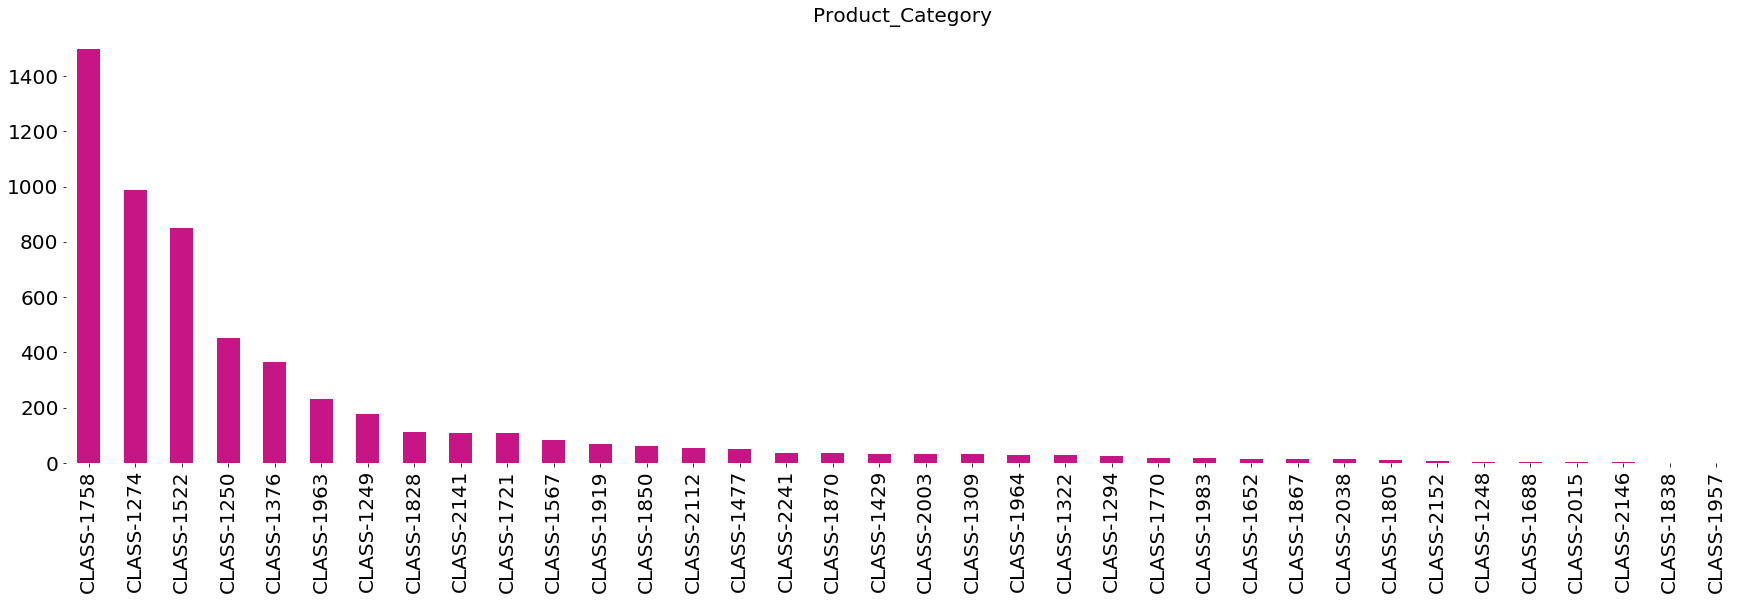

In [16]:
import seaborn as sns
ax = train['Product_Category'].value_counts().plot.bar(
    figsize = (30,8),
    color = 'mediumvioletred',
    fontsize = 20
)
ax.set_title('Product_Category',fontsize = 20)
sns.despine(bottom = True, left = True)

In [17]:
train['GL_Code'].value_counts()

GL-6050310    1618
GL-2182000    1297
GL-6050100     962
GL-6101400     802
GL-6100410     388
GL-6100500     220
GL-6060100     158
GL-6121905      89
GL-6020600      32
Name: GL_Code, dtype: int64

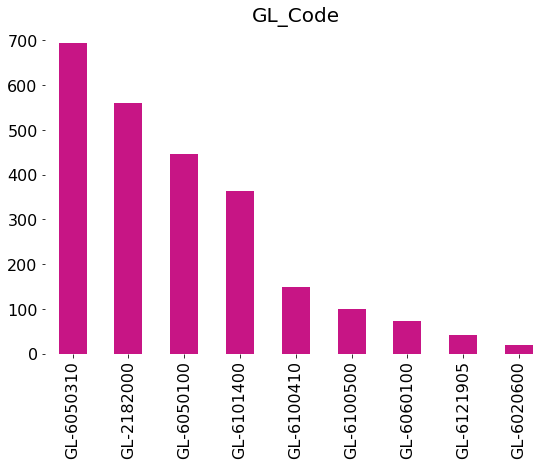

In [18]:
import seaborn as sns
ax = test['GL_Code'].value_counts().plot.bar(
    figsize = (9,6),
    color = 'mediumvioletred',
    fontsize = 16
)
ax.set_title('GL_Code',fontsize = 20)
sns.despine(bottom = True, left = True)

In [19]:
train['Vendor_Code'].value_counts()

VENDOR-1883    330
VENDOR-1513    253
VENDOR-1944    179
VENDOR-1551    175
VENDOR-2513    170
VENDOR-1066    126
VENDOR-2408    114
VENDOR-1873    112
VENDOR-1771    111
VENDOR-1191    102
VENDOR-1802     88
VENDOR-1065     85
VENDOR-2416     83
VENDOR-1069     71
VENDOR-1676     66
VENDOR-1080     65
VENDOR-2478     59
VENDOR-2333     55
VENDOR-2116     50
VENDOR-2514     45
VENDOR-1717     44
VENDOR-2117     39
VENDOR-1554     39
VENDOR-2120     38
VENDOR-1062     35
VENDOR-1608     33
VENDOR-1955     32
VENDOR-2160     31
VENDOR-1254     30
VENDOR-1114     30
              ... 
VENDOR-1436      1
VENDOR-1088      1
VENDOR-1413      1
VENDOR-1666      1
VENDOR-2486      1
VENDOR-2441      1
VENDOR-1924      1
VENDOR-1082      1
VENDOR-2185      1
VENDOR-2124      1
VENDOR-2111      1
VENDOR-1980      1
VENDOR-1575      1
VENDOR-2236      1
VENDOR-2405      1
VENDOR-1285      1
VENDOR-1061      1
VENDOR-2539      1
VENDOR-1158      1
VENDOR-2342      1
VENDOR-2149      1
VENDOR-2312 

In [20]:
len(train['Vendor_Code'].unique())

1253

In [21]:
train['Product_Category'].unique()

array(['CLASS-1963', 'CLASS-1250', 'CLASS-1274', 'CLASS-1522',
       'CLASS-1376', 'CLASS-1758', 'CLASS-2141', 'CLASS-1429',
       'CLASS-1652', 'CLASS-1249', 'CLASS-1721', 'CLASS-1870',
       'CLASS-1828', 'CLASS-2112', 'CLASS-1567', 'CLASS-1309',
       'CLASS-1477', 'CLASS-1805', 'CLASS-1919', 'CLASS-1322',
       'CLASS-1838', 'CLASS-2015', 'CLASS-1850', 'CLASS-2003',
       'CLASS-1248', 'CLASS-1964', 'CLASS-2241', 'CLASS-1867',
       'CLASS-1983', 'CLASS-1294', 'CLASS-1688', 'CLASS-2038',
       'CLASS-1770', 'CLASS-2152', 'CLASS-2146', 'CLASS-1957'],
      dtype=object)

In [22]:
train1=pd.get_dummies(train['GL_Code'],drop_first=True)
train1.head()

,GL-6020600,GL-6050100,GL-6050310,GL-6060100,GL-6100410,GL-6100500,GL-6101400,GL-6121905
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0


In [23]:
test1=pd.get_dummies(test['GL_Code'],drop_first=True)
test1.head()

,GL-6020600,GL-6050100,GL-6050310,GL-6060100,GL-6100410,GL-6100500,GL-6101400,GL-6121905
0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [24]:
test_id=test['Inv_Id']

In [25]:
test.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description
0,15003,VENDOR-2513,GL-6050310,56.13,Travel and Entertainment Miscellaneous Company...
1,15008,VENDOR-1044,GL-6101400,96.56,Final Site Clean Up Store Construction Advance...
2,15013,VENDOR-1254,GL-6101400,55.93,Arabian American Development Co Final Site Cle...
3,15019,VENDOR-1331,GL-2182000,32.62,Corporate Services Contingent Labor/Temp Labor...
4,15020,VENDOR-2513,GL-6050310,25.81,Fortune National Corp Miscellaneous Company Ca...


In [26]:
tfidf_vect = TfidfVectorizer(sublinear_tf=True, norm='l2',encoding='latin-1',stop_words='english')
tfidf_vect.fit_transform(train['Item_Description'].values.tolist() + test['Item_Description'].values.tolist())

<8012x2315 sparse matrix of type '<class 'numpy.float64'>'
	with 91665 stored elements in Compressed Sparse Row format>

In [27]:
train_tfidf = tfidf_vect.transform(train['Item_Description'].values.tolist())
test_tfidf = tfidf_vect.transform(test['Item_Description'].values.tolist())

In [28]:
train=pd.concat([train,train1],axis=1)
train.drop(['Inv_Id','GL_Code','Vendor_Code','Item_Description','Product_Category'],axis=1,inplace=True)

In [29]:
test=pd.concat([test,test1],axis=1)
test.drop(['Inv_Id','GL_Code','Vendor_Code','Item_Description'],axis=1,inplace=True)

In [30]:
train_tfidf

<5566x2315 sparse matrix of type '<class 'numpy.float64'>'
	with 63638 stored elements in Compressed Sparse Row format>

In [31]:
train.head()

,Inv_Amt,GL-6020600,GL-6050100,GL-6050310,GL-6060100,GL-6100410,GL-6100500,GL-6101400,GL-6121905
0,83.24,0,0,0,0,1,0,0,0
1,51.18,0,0,0,0,0,0,0,0
2,79.02,0,1,0,0,0,0,0,0
3,48.50,0,0,0,0,0,0,1,0
4,63.35,0,0,0,0,0,0,0,0


In [32]:
train_features = hstack([
    train_tfidf,
    train,],'csr'
)

In [33]:
test_features = hstack([
    test_tfidf,
    test,],'csr'
)

In [34]:
params = {
    'num_leaves': 15,
    'min_data_in_leaf': 10,
    'objective': 'multiclass',
    'max_depth': 6,
    'learning_rate': 0.05,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 36,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(36, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(train_features, label=y_train)
eval_hist = lgb.cv(params, train_set, nfold=4, num_boost_round=700,
                   early_stopping_rounds=30, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(test_features, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))

C:\Users\dk283\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Timer: 25.4s


In [35]:
predictions

array([[9.96207906e-06, 5.54909080e-05, 1.10294477e-04, ...,
        4.96153622e-06, 1.08968366e-05, 2.22277978e-05],
       [1.02068944e-05, 6.42408739e-05, 1.27686028e-04, ...,
        5.74388551e-06, 1.43727258e-05, 2.57327409e-05],
       [1.02069123e-05, 6.42409868e-05, 1.27686252e-04, ...,
        5.74389561e-06, 1.26151032e-05, 2.57327861e-05],
       ...,
       [2.30598659e-05, 7.44332998e-05, 9.98040520e-01, ...,
        8.22212098e-06, 1.46165837e-05, 2.98154851e-05],
       [1.40490778e-05, 8.84230793e-05, 1.75750905e-04, ...,
        7.90605752e-06, 1.73637786e-05, 3.54193218e-05],
       [3.40841281e-05, 2.06122778e-04, 4.09692415e-04, ...,
        2.93012097e-05, 4.04766530e-05, 8.25658763e-05]])

In [36]:
idx = predictions.argmax(axis=1)
y_predx = (idx[:,None] == np.arange(predictions.shape[1])).astype(int)
y_predx

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
y_predx = [np.where(r == 1)[0][0] for r in y_predx]

In [38]:
y_predx

[15,
 10,
 10,
 7,
 15,
 15,
 2,
 15,
 1,
 20,
 15,
 3,
 10,
 1,
 10,
 22,
 31,
 35,
 10,
 15,
 10,
 2,
 2,
 32,
 23,
 3,
 7,
 2,
 15,
 11,
 15,
 10,
 10,
 20,
 2,
 2,
 15,
 3,
 32,
 15,
 3,
 3,
 5,
 15,
 18,
 10,
 10,
 1,
 15,
 15,
 25,
 15,
 10,
 15,
 3,
 10,
 10,
 10,
 25,
 10,
 8,
 3,
 15,
 23,
 10,
 1,
 15,
 15,
 7,
 8,
 10,
 15,
 10,
 15,
 23,
 1,
 15,
 2,
 2,
 15,
 3,
 15,
 3,
 25,
 14,
 15,
 10,
 10,
 10,
 3,
 10,
 8,
 3,
 7,
 10,
 1,
 15,
 14,
 3,
 15,
 7,
 10,
 7,
 7,
 3,
 3,
 15,
 15,
 10,
 15,
 3,
 32,
 10,
 15,
 3,
 3,
 1,
 2,
 6,
 3,
 10,
 18,
 4,
 15,
 15,
 10,
 6,
 10,
 15,
 11,
 15,
 18,
 7,
 15,
 15,
 15,
 28,
 10,
 10,
 10,
 15,
 2,
 15,
 2,
 7,
 22,
 7,
 15,
 3,
 15,
 11,
 15,
 25,
 3,
 10,
 10,
 3,
 3,
 15,
 6,
 2,
 2,
 3,
 14,
 15,
 15,
 3,
 7,
 1,
 25,
 3,
 15,
 10,
 2,
 2,
 15,
 10,
 15,
 10,
 10,
 3,
 25,
 20,
 15,
 9,
 7,
 3,
 15,
 3,
 2,
 2,
 15,
 3,
 3,
 17,
 3,
 18,
 15,
 3,
 11,
 1,
 7,
 15,
 15,
 25,
 22,
 10,
 7,
 11,
 2,
 25,
 3,
 15,
 10,
 9,
 3,
 23,


In [39]:
y_predx=le.inverse_transform(y_predx)

In [40]:
y_predx

array(['CLASS-1758', 'CLASS-1522', 'CLASS-1522', ..., 'CLASS-1250',
       'CLASS-1963', 'CLASS-1964'], dtype=object)

In [41]:
columns = ['Product_Category']
df1 = pd.DataFrame(data=y_predx, columns=columns)
df1['Inv_Id'] = test_id
df1 = df1[['Inv_Id','Product_Category']]

In [42]:
df1.head()

,Inv_Id,Product_Category
0,15003,CLASS-1758
1,15008,CLASS-1522
2,15013,CLASS-1522
3,15019,CLASS-1376
4,15020,CLASS-1758


In [43]:
df1.to_csv("infosys.csv", index=False)